<a href="https://colab.research.google.com/github/patofw/imf_master/blob/master/Google_Colab/Boston_Crimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crimenes de Boston

Bienvenido Agente Data, Big Data. Hemos sido contactados por el departamento de Policía de la ciudad de Boston. El alcalde cree que existe la posibilidad de predecir la cantidad de crímenes que suceden en su ciudad. Tu objetivo es analizar los datos de la ciudad y buscar patrones que nos permitan determinar la factibilidad de un modelo. 

Esta misión es de suma importancia! Mucha suerte!!!

In [0]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium.plugins import HeatMap


%matplotlib inline 

In [3]:
# carga la data
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Google_Colab/crimes.csv'
data = pd.read_csv(url, encoding='latin-1', sep = ';')

# cabecera
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,REPORTING_AREA,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,Location
0,I182070304,1107,Fraud,905,1/11/2017 0:00,2017,11,Wednesday,0,Part Two,"(42.33926764, -71.07208833)"
1,I182070115,3114,Investigate Property,793,11/10/2017 17:43,2017,10,Wednesday,17,Part Three,"(42.34650102, -71.13612792)"
2,I182069920,3201,Property Lost,287,31/8/2017 12:08,2017,8,Thursday,12,Part Three,"(42.33192532, -71.08411222)"
3,I182069657,1102,Fraud,774,27/6/2017 7:00,2017,6,Tuesday,7,Part Two,"(42.33848236, -71.15288978)"
4,I182069334,3201,Property Lost,420,8/12/2017 22:00,2017,12,Friday,22,Part Three,"(42.27959103, -71.08132258)"


En este caso nos enfocaremos en una exploración previa sencilla sobre los tipos de crímenes para luego pasar al procesamiento de fechas Agente Data. 
Para empezar cuál es el tipo de crímenes más común?? 

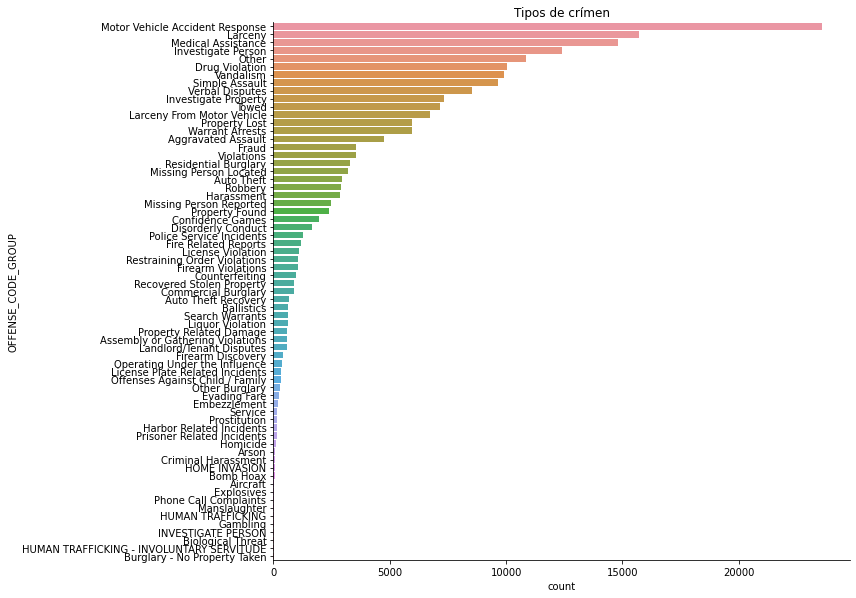

In [4]:
# Countplot for crime types
sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
            height=8, 
            aspect=1.5,
            order= data.OFFENSE_CODE_GROUP.value_counts().index, # ordenamos de mayor a menor 
           data=data)
plt.title("Tipos de crímen")
plt.show();

Hmm. Pues podemos ver las incidencias y las respuestas de la policía a diferentes casos, pero no todos parecen un crímen. El alcalde nos ha dicho que solo aquellas que pertenecen a 'Part One' en la variable 'UCR_PART' tratan con crímenes serios y violentos. Desde ahora utilizaremos sólo esos casos...

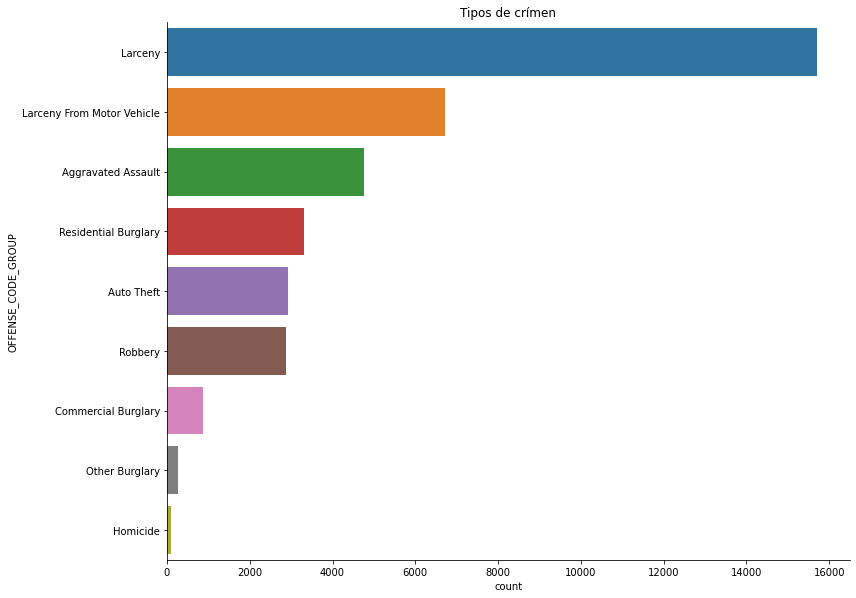

In [5]:
data = data[data.UCR_PART == 'Part One'] # reemplazamos dataset original para ahorrar memoria, cuidado con esto!
# Volvemos a ejecutar el tipo de crímen
sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
            height=8, 
            aspect=1.5,
            order= data.OFFENSE_CODE_GROUP.value_counts().index, # ordenamos de mayor a menor 
           data=data)
plt.title("Tipos de crímen")
plt.show();

Buen trabajo agente. Podemos ver a qué hora ocurren los crímenes??


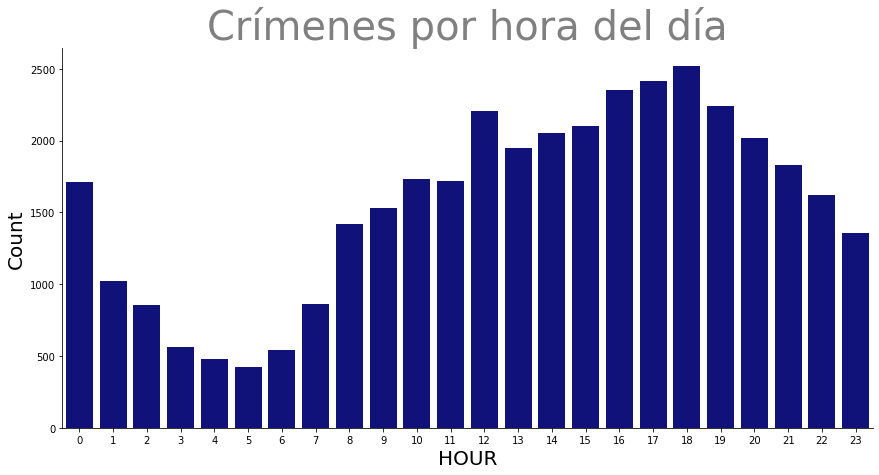

In [6]:
# Crimen por hora del día
sns.catplot(x='HOUR',
           kind='count',
            height=6, 
            aspect=2,
            color='darkblue',
           data=data)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('HOUR', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title("Crímenes por hora del día",fontsize=40,color = "grey")
plt.show();

La noche es en efecto más peligrosa Agente Big Data. También hay un pico de crímen a la hora del almuerzo...

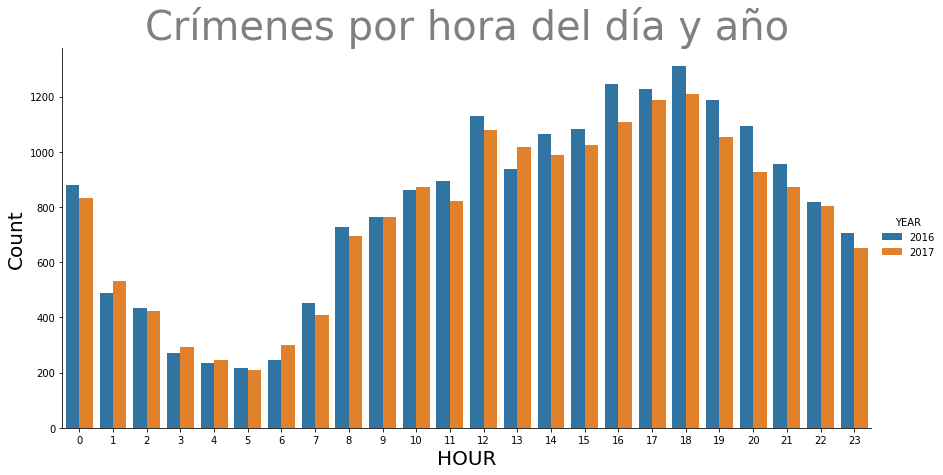

In [7]:
# Crimen por hora del día y año 
sns.catplot(x='HOUR',
           kind='count',
            hue = "YEAR", # separamos los años 
            height=6, 
            aspect=2,
           data=data)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('HOUR', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title("Crímenes por hora del día y año",fontsize=40,color = "grey")
plt.show();

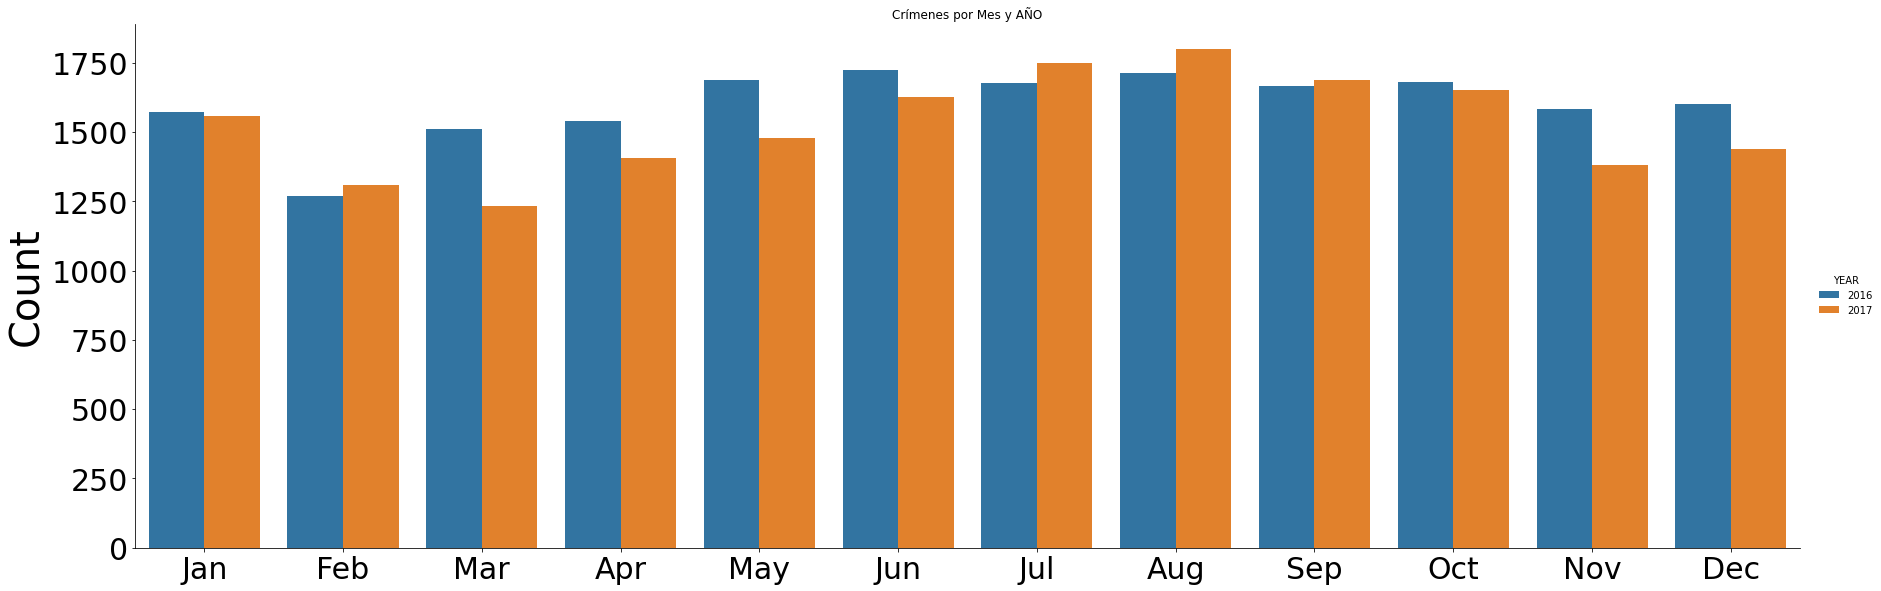

In [8]:
# Crimes by month of year
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.catplot(x='MONTH',
           kind='count',
           hue = "YEAR",
            height=8, 
            aspect=3,
           data=data)
plt.xticks(np.arange(12), months, size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)
plt.title("Crímenes por Mes y AÑO")
plt.show();

#### Qué nos dicen los anteriores gráficos?

## Tratamiento de Fechas

In [0]:
# Tratamiento de Fechas 
# El formato de fechas es 23/10/2017 13:58	
# Transformamos el formato a fecha 
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'], 
                                          format='%d/%m/%Y %H:%M') # pandas tiene su API con datetime
data.sort_values('OCCURRED_ON_DATE', inplace = True) #ordenamos por fecha
                                        

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37538 entries, 154142 to 1540
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   INCIDENT_NUMBER     37538 non-null  object        
 1   OFFENSE_CODE        37538 non-null  int64         
 2   OFFENSE_CODE_GROUP  37538 non-null  object        
 3   REPORTING_AREA      37538 non-null  object        
 4   OCCURRED_ON_DATE    37538 non-null  datetime64[ns]
 5   YEAR                37538 non-null  int64         
 6   MONTH               37538 non-null  int64         
 7   DAY_OF_WEEK         37538 non-null  object        
 8   HOUR                37538 non-null  int64         
 9   UCR_PART            37538 non-null  object        
 10  Location            37538 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 3.4+ MB


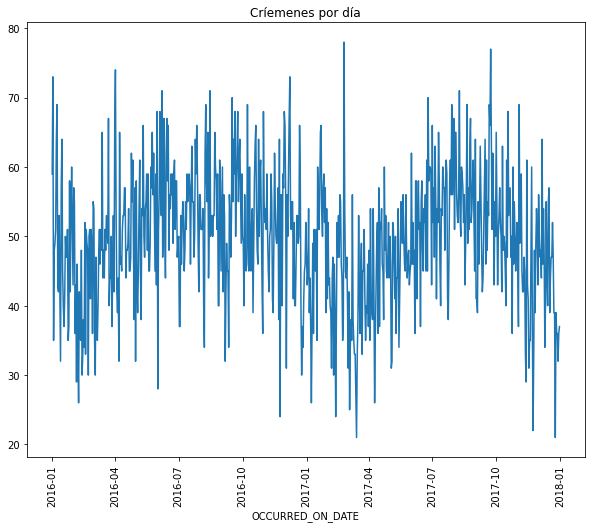

In [11]:
# Crimenes únicos por día en la serie temporal 
serie = data.groupby(by=data['OCCURRED_ON_DATE'].dt.date)['INCIDENT_NUMBER'].nunique()
# ploteamos
serie.plot(title='Críemenes por día',figsize=(10,8))
plt.xticks(rotation = 90)
plt.show();

** Ahora tenemos una serie Temporal interesante!!

Podemos buscar los Outliers??

In [0]:
def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show();
    if return_mask: 
      return outlier_idx

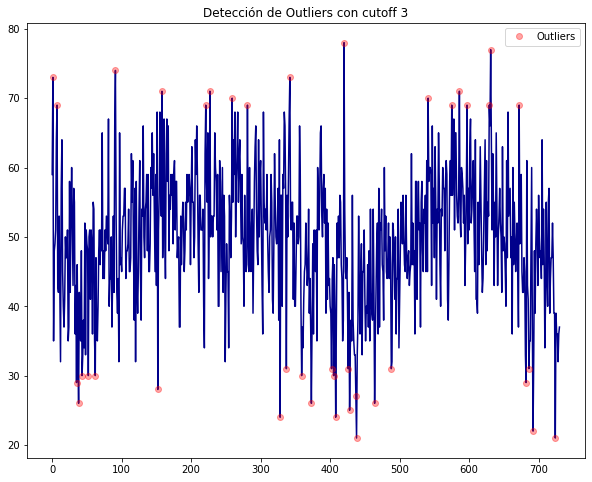

In [13]:
indices = plot_outliers_signal(serie.values, threshold = 3)


In [14]:
# En qué fechas hubo outliers ?
serie[indices]

OCCURRED_ON_DATE
2016-01-02    73
2016-01-08    69
2016-02-05    29
2016-02-08    26
2016-02-13    30
2016-02-22    30
2016-03-03    30
2016-04-01    74
2016-06-01    28
2016-06-07    71
2016-08-09    69
2016-08-15    71
2016-09-16    70
2016-10-08    69
2016-11-24    24
2016-12-03    31
2016-12-08    73
2016-12-25    30
2017-01-08    26
2017-02-06    31
2017-02-09    30
2017-02-12    24
2017-02-24    78
2017-03-02    31
2017-03-04    25
2017-03-13    27
2017-03-14    21
2017-04-09    26
2017-05-03    31
2017-06-25    70
2017-07-29    69
2017-08-09    71
2017-08-20    69
2017-09-21    69
2017-09-23    77
2017-11-03    69
2017-11-13    29
2017-11-17    31
2017-11-23    22
2017-12-25    21
Name: INCIDENT_NUMBER, dtype: int64

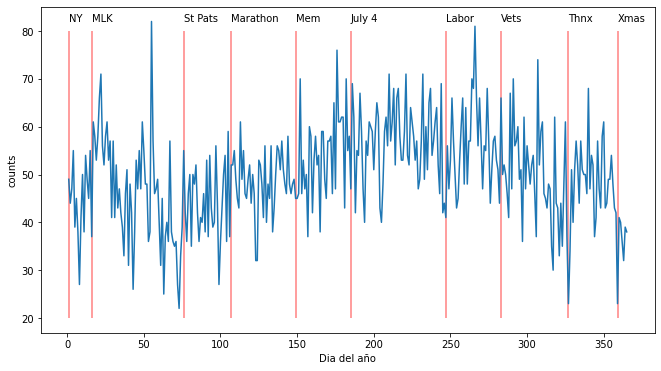

In [15]:
import datetime as dt

# Algunas fechas caen cerca de festivos en EEUU. Con un poco de investigacion sacamos los festivos
data['Day_of_year'] = data.OCCURRED_ON_DATE.dt.dayofyear # Otra forma de organizar por fecha
data_holidays = data[data.YEAR == 2017].groupby(['Day_of_year']).size().reset_index(name='counts')

# FECHAS FESTIVAS EN 2017
holidays = pd.Series(['2017-01-01', # New Years Day
                     '2017-01-16', # MLK Day
                     '2017-03-17', # St. Patrick's Day
                     '2017-04-17', # Boston marathon
                     '2017-05-29', # Memorial Day
                     '2017-07-04', # Independence Day
                     '2017-09-04', # Labor Day
                     '2017-10-10', # Veterans Day
                     '2017-11-23', # Thanksgiving
                     '2017-12-25']) # Christmas
holidays = pd.to_datetime(holidays).dt.dayofyear # a datetime, luego dia del año
holidays_names = ['NY',
                 'MLK',
                 'St Pats',
                 'Marathon',
                 'Mem',
                 'July 4',
                 'Labor',
                 'Vets',
                 'Thnx',
                 'Xmas']

# Plot crimes and holidays
fig, ax = plt.subplots(figsize=(11,6))
sns.lineplot(x='Day_of_year',
            y='counts',
            ax=ax,
            data=data_holidays)
plt.xlabel('Dia del año')
plt.vlines(holidays, 20, 80, alpha=0.5, color ='r')
for i in range(len(holidays)):
    plt.text(x=holidays[i], y=82, s=holidays_names[i])

### Podemos darle alguna categría a la serie? Capaz por crimen?

In [49]:
# filtramos 2017 
condition = (data.YEAR == 2017) # creamos una condicion de filtro
# Agrupamos por día y tipo de crimen 
data_2017 = data[condition]
by_day_n_crime = data_2017.groupby(['Day_of_year',
                               'OFFENSE_CODE_GROUP'])["INCIDENT_NUMBER"].count()

# Nos queda una serie multi-indice
# con un unstack podemos convertirlo en una tabla plana nuevamente 
by_day_n_crime = by_day_n_crime.unstack()
# reemplazamos NaNs por 0 ya que en este caso serían lo mismo 
by_day_n_crime.fillna(0, inplace = True) # inplace lo sobreescribe
# La podemos ordenar for filas 
by_day_n_crime.sort_values(1, axis=1, inplace = True) # axis 0->columnas; axis 1->filas
by_day_n_crime.head()

OFFENSE_CODE_GROUP,Commercial Burglary,Homicide,Other Burglary,Residential Burglary,Auto Theft,Robbery,Larceny From Motor Vehicle,Aggravated Assault,Larceny
Day_of_year,,,,,,,,,
1,0.0,0.0,0.0,2.0,4.0,6.0,8.0,13.0,16.0
2,2.0,0.0,0.0,4.0,1.0,4.0,8.0,9.0,16.0
3,0.0,0.0,0.0,2.0,1.0,7.0,13.0,7.0,17.0
4,0.0,0.0,0.0,5.0,5.0,4.0,10.0,5.0,26.0
5,0.0,0.0,0.0,0.0,5.0,6.0,11.0,5.0,12.0


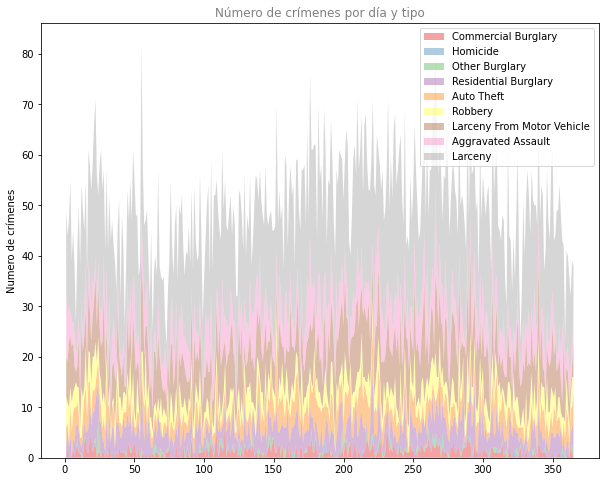

In [51]:
eje_x = by_day_n_crime.index # dias del año en X
# Creamos una lista de series para el eje Y
series_y = []
for c in by_day_n_crime.columns:
  y = by_day_n_crime[c].values  # Valores individuales por serie. 
  series_y.append(y)

# Creamos el Plot 

plt.figure(figsize=(10,8)) # tamaño de la figura
pal = sns.color_palette("Set1") # pallete de colores 
plt.stackplot(eje_x,series_y, 
              labels=by_day_n_crime.columns, # la leyenda
              colors=pal, # ya que son muchos colores, escogemos un pallete
              alpha=0.4 # transparencia por serie 
              )
plt.legend(loc='upper right')
plt.title("Número de crímenes por día y tipo", color = "grey")
plt.ylabel("Numero de crímenes")
plt.show();
 

# Geolocalización del Crimen 

Buen trabajo Agente Big Data, es un interesante análisis. La serie muestra una clara temporalidad e imagino que podríamos utilizar datos históricos para construir un modelo predictivo del crimen. Pero solo saber cuándo no es suficiente, podemos geolocalizar los atentados a la seguridad?

In [97]:
# Tenemos las coordenadas en una tupla 
# Podemos usar esa información directamente. 
data.Location.values[:3]

array(['(42.34531664, -71.14298078)', '(42.31893277, -71.04541663)',
       '(42.32195809, -71.08351213)'], dtype=object)

In [109]:

geos = data[condition] # filtramos solo 2017
geos = geos.Location.dropna().values # quitamos nulos y guardamos en un array
# geos son una tupla, pero vienen en formato string 
type(geos[0])

str

In [0]:
#usamos la funcion eval para interpretar el string como tupla 

geos = [eval(geo) for geo in geos]

In [111]:
# Creamos punto fijo del mapa para visualización inicial 
crime_map = folium.Map(location=[42.31,-71.08], 
                       tiles = "Stamen Toner", # le damos un toque de batman
                      zoom_start = 10)

# creamos una capa de mapa de calor y la añadimos al mapa, en una línea...
HeatMap(geos, radius=10).add_to(crime_map)

# Plot!
crime_map

Gran trabajo agente Big Data! 